# Building an LSTM model to predict the price of NABIL

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Timestamp in Days")
    plt.ylabel("Rupees")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [4]:
# Read in data
nabil = pd.read_csv('../Data/NabilModifiedDate.csv')

# Convert series into datetime type
nabil['Date'] = pd.to_datetime(nabil['Date'])

# Save target series
series = nabil['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(nabil.Date == train_split_date)[0][0]
x_train = nabil.loc[nabil['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-01-03'
test_split_index = np.where(nabil.Date == test_split_date)[0][0]
x_test = nabil.loc[nabil['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = nabil.loc[(nabil['Date'] < test_split_date) & (nabil['Date'] > train_split_date)]['Close']

1479 1480 1663 1664 2144


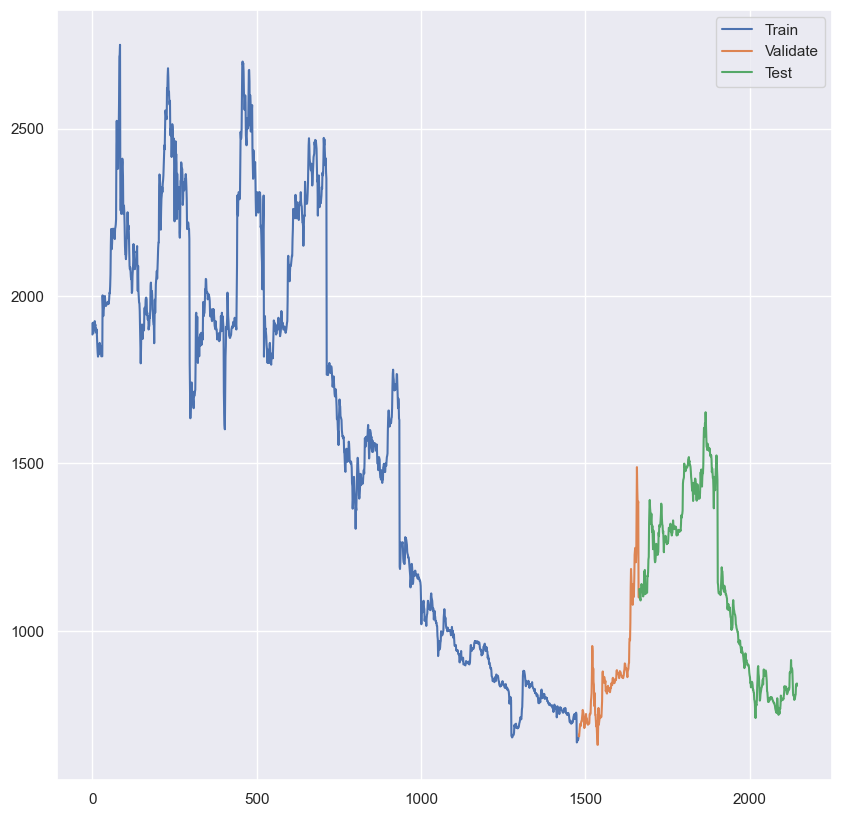

In [5]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
plt.savefig('../Images/LSTM/LSTM TRAIN TEST SPLIT')
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [6]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
nabil_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [7]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [8]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                      batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-5)  # Use the legacy Nadam optimizer

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])


Epoch 1/100
73/73 [==============================] - 3s 12ms/step - loss: 0.0974 - mae: 0.3676 - lr: 1.0000e-05
Epoch 2/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0686 - mae: 0.3002 - lr: 1.1220e-05
Epoch 3/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0364 - mae: 0.2096 - lr: 1.2589e-05
Epoch 4/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0118 - mae: 0.1167 - lr: 1.4125e-05
Epoch 5/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0039 - mae: 0.0651 - lr: 1.5849e-05
Epoch 6/100
73/73 [==============================] - 1s 9ms/step - loss: 0.0033 - mae: 0.0572 - lr: 1.7783e-05
Epoch 7/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0032 - mae: 0.0558 - lr: 1.9953e-05
Epoch 8/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0032 - mae: 0.0544 - lr: 2.2387e-05
Epoch 9/100
73/73 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0530 - lr: 2.5119e-05


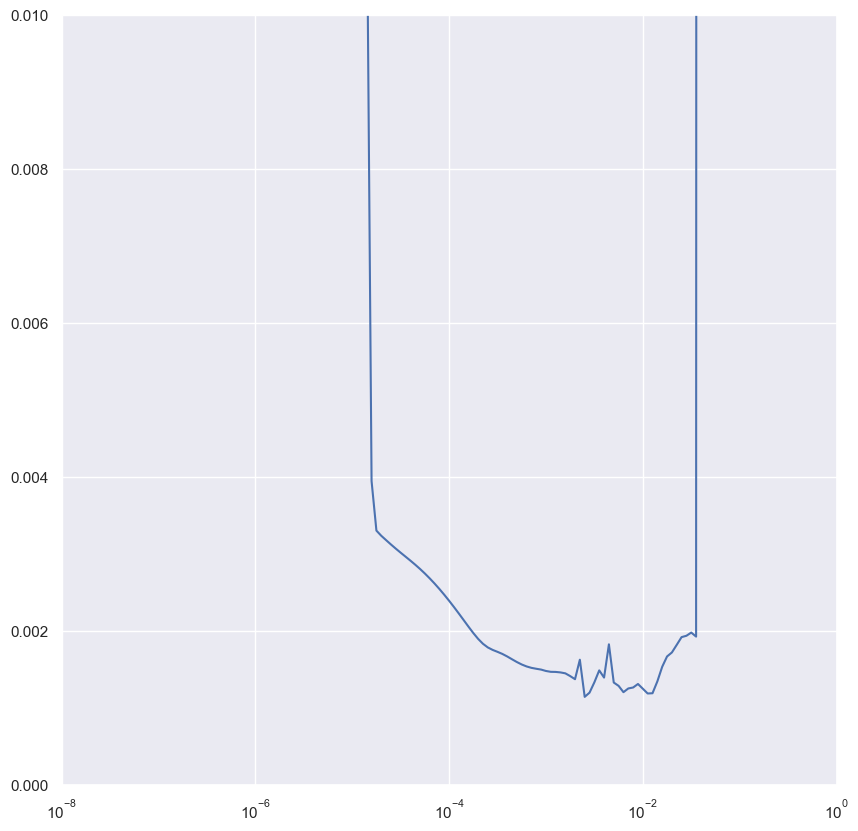

In [9]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])
plt.savefig('../Images/LSTM/LSTM LEARNING RATE PLOT')

## Build and Train LSTM Model

In [10]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'reset_states'):
            optimizer.reset_states()

# Reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# Create model
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                      batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
])

# Set optimizer (use the legacy Nadam optimizer)
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-4)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Reset states
reset_states = ResetStatesCallback()

# Set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# Fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])


Epoch 1/500
     48/Unknown - 3s 10ms/step - loss: 0.0597 - mae: 0.2600INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 7s 92ms/step - loss: 0.0585 - mae: 0.2560 - val_loss: 0.0014 - val_mae: 0.0486
Epoch 2/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0524INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 0.0028 - mae: 0.0522 - val_loss: 0.0011 - val_mae: 0.0406
Epoch 3/500
48/49 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0516INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0029 - mae: 0.0514 - val_loss: 0.0010 - val_mae: 0.0366
Epoch 4/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0502INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0028 - mae: 0.0494 - val_loss: 9.2214e-04 - val_mae: 0.0337
Epoch 5/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0484INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0026 - mae: 0.0475 - val_loss: 8.6447e-04 - val_mae: 0.0314
Epoch 6/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0468INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0025 - mae: 0.0458 - val_loss: 8.2134e-04 - val_mae: 0.0296
Epoch 7/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0453INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0024 - mae: 0.0442 - val_loss: 7.8731e-04 - val_mae: 0.0282
Epoch 8/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0439INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0023 - mae: 0.0428 - val_loss: 7.5908e-04 - val_mae: 0.0270
Epoch 9/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0426INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0022 - mae: 0.0414 - val_loss: 7.3462e-04 - val_mae: 0.0261
Epoch 10/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0414INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 78ms/step - loss: 0.0021 - mae: 0.0401 - val_loss: 7.1263e-04 - val_mae: 0.0252
Epoch 11/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0402INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0021 - mae: 0.0389 - val_loss: 6.9226e-04 - val_mae: 0.0245
Epoch 12/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0390INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0020 - mae: 0.0378 - val_loss: 6.7295e-04 - val_mae: 0.0238
Epoch 13/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0375INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0019 - mae: 0.0366 - val_loss: 6.5435e-04 - val_mae: 0.0232
Epoch 14/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0368INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0018 - mae: 0.0355 - val_loss: 6.3624e-04 - val_mae: 0.0227
Epoch 15/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0357INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0018 - mae: 0.0344 - val_loss: 6.1851e-04 - val_mae: 0.0221
Epoch 16/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0346INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0017 - mae: 0.0333 - val_loss: 6.0122e-04 - val_mae: 0.0217
Epoch 17/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0335INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0016 - mae: 0.0322 - val_loss: 5.8460e-04 - val_mae: 0.0212
Epoch 18/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0326INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 5.6902e-04 - val_mae: 0.0209
Epoch 19/500
48/49 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0309INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 96ms/step - loss: 0.0015 - mae: 0.0305 - val_loss: 5.5500e-04 - val_mae: 0.0206
Epoch 20/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0309INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 5.4305e-04 - val_mae: 0.0204
Epoch 21/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0310INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 5.3344e-04 - val_mae: 0.0203
Epoch 22/500
49/49 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0294INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0015 - mae: 0.0294 - val_loss: 5.2606e-04 - val_mae: 0.0202
Epoch 23/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0309INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 5.2045e-04 - val_mae: 0.0202
Epoch 24/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0308INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 5.1597e-04 - val_mae: 0.0202
Epoch 25/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0308INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0014 - mae: 0.0291 - val_loss: 5.1203e-04 - val_mae: 0.0202
Epoch 26/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0307INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0014 - mae: 0.0290 - val_loss: 5.0823e-04 - val_mae: 0.0202
Epoch 27/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0305INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0014 - mae: 0.0289 - val_loss: 5.0438e-04 - val_mae: 0.0201
Epoch 28/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0304INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0014 - mae: 0.0287 - val_loss: 5.0039e-04 - val_mae: 0.0201
Epoch 29/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0302INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 4.9628e-04 - val_mae: 0.0200
Epoch 30/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0300INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 0.0013 - mae: 0.0284 - val_loss: 4.9208e-04 - val_mae: 0.0199
Epoch 31/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0298INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 107ms/step - loss: 0.0013 - mae: 0.0282 - val_loss: 4.8785e-04 - val_mae: 0.0198
Epoch 32/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0014 - mae: 0.0302INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 4.8364e-04 - val_mae: 0.0197
Epoch 33/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0294INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 4.7949e-04 - val_mae: 0.0196
Epoch 34/500
47/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0286INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 4.7543e-04 - val_mae: 0.0195
Epoch 35/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0290INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 0.0013 - mae: 0.0274 - val_loss: 4.7148e-04 - val_mae: 0.0194
Epoch 36/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0288INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0012 - mae: 0.0273 - val_loss: 4.6767e-04 - val_mae: 0.0193
Epoch 37/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0286INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 4.6399e-04 - val_mae: 0.0192
Epoch 38/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0284INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 4.6046e-04 - val_mae: 0.0191
Epoch 39/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0282INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 0.0012 - mae: 0.0267 - val_loss: 4.5705e-04 - val_mae: 0.0190
Epoch 40/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0281INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 4.5377e-04 - val_mae: 0.0189
Epoch 41/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0279INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 4.5060e-04 - val_mae: 0.0189
Epoch 42/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0277INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 4.4753e-04 - val_mae: 0.0188
Epoch 43/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0276INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0011 - mae: 0.0261 - val_loss: 4.4454e-04 - val_mae: 0.0187
Epoch 44/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0274INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0011 - mae: 0.0259 - val_loss: 4.4163e-04 - val_mae: 0.0186
Epoch 45/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0273INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0011 - mae: 0.0258 - val_loss: 4.3878e-04 - val_mae: 0.0186
Epoch 46/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0271INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0011 - mae: 0.0257 - val_loss: 4.3598e-04 - val_mae: 0.0185
Epoch 47/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0270INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 0.0011 - mae: 0.0255 - val_loss: 4.3323e-04 - val_mae: 0.0184
Epoch 48/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0268INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 4.3053e-04 - val_mae: 0.0184
Epoch 49/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0267INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 4.2786e-04 - val_mae: 0.0183
Epoch 50/500
48/49 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0255INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 0.0011 - mae: 0.0251 - val_loss: 4.2523e-04 - val_mae: 0.0182
Epoch 51/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0264INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 4.2264e-04 - val_mae: 0.0182
Epoch 52/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0267INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 0.0010 - mae: 0.0248 - val_loss: 4.2009e-04 - val_mae: 0.0181
Epoch 53/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0261INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 0.0010 - mae: 0.0247 - val_loss: 4.1757e-04 - val_mae: 0.0181
Epoch 54/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0260INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 4.1508e-04 - val_mae: 0.0180
Epoch 55/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0258INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 4.1264e-04 - val_mae: 0.0179
Epoch 56/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0257INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 4.1024e-04 - val_mae: 0.0179
Epoch 57/500
45/49 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0260INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 9.9016e-04 - mae: 0.0242 - val_loss: 4.0788e-04 - val_mae: 0.0178
Epoch 58/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 9.7999e-04 - mae: 0.0241 - val_loss: 4.0556e-04 - val_mae: 0.0178
Epoch 59/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0253INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 9.6994e-04 - mae: 0.0239 - val_loss: 4.0329e-04 - val_mae: 0.0177
Epoch 60/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0251INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 9.6001e-04 - mae: 0.0238 - val_loss: 4.0107e-04 - val_mae: 0.0177
Epoch 61/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0250INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 9.5019e-04 - mae: 0.0237 - val_loss: 3.9889e-04 - val_mae: 0.0176
Epoch 62/500
46/49 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0249INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 9.4050e-04 - mae: 0.0236 - val_loss: 3.9678e-04 - val_mae: 0.0176
Epoch 63/500
46/49 [===========================>..] - ETA: 0s - loss: 9.9105e-04 - mae: 0.0247INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 9.3093e-04 - mae: 0.0234 - val_loss: 3.9472e-04 - val_mae: 0.0175
Epoch 64/500
46/49 [===========================>..] - ETA: 0s - loss: 9.8099e-04 - mae: 0.0246INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 9.2148e-04 - mae: 0.0233 - val_loss: 3.9272e-04 - val_mae: 0.0175
Epoch 65/500
46/49 [===========================>..] - ETA: 0s - loss: 9.7106e-04 - mae: 0.0245INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 9.1216e-04 - mae: 0.0232 - val_loss: 3.9078e-04 - val_mae: 0.0174
Epoch 66/500
46/49 [===========================>..] - ETA: 0s - loss: 9.6127e-04 - mae: 0.0244INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 9.0297e-04 - mae: 0.0231 - val_loss: 3.8892e-04 - val_mae: 0.0174
Epoch 67/500
49/49 [==============================] - ETA: 0s - loss: 8.9390e-04 - mae: 0.0230INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 8.9390e-04 - mae: 0.0230 - val_loss: 3.8713e-04 - val_mae: 0.0174
Epoch 68/500
46/49 [===========================>..] - ETA: 0s - loss: 9.4211e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 8.8497e-04 - mae: 0.0228 - val_loss: 3.8542e-04 - val_mae: 0.0173
Epoch 69/500
46/49 [===========================>..] - ETA: 0s - loss: 9.3275e-04 - mae: 0.0240INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 8.7618e-04 - mae: 0.0227 - val_loss: 3.8379e-04 - val_mae: 0.0173
Epoch 70/500
45/49 [==========================>...] - ETA: 0s - loss: 9.4371e-04 - mae: 0.0243INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 8.6753e-04 - mae: 0.0226 - val_loss: 3.8226e-04 - val_mae: 0.0172
Epoch 71/500
48/49 [============================>.] - ETA: 0s - loss: 8.7665e-04 - mae: 0.0229INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 98ms/step - loss: 8.5903e-04 - mae: 0.0225 - val_loss: 3.8082e-04 - val_mae: 0.0172
Epoch 72/500
47/49 [===========================>..] - ETA: 0s - loss: 8.8640e-04 - mae: 0.0232INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 8.5067e-04 - mae: 0.0224 - val_loss: 3.7949e-04 - val_mae: 0.0172
Epoch 73/500
46/49 [===========================>..] - ETA: 0s - loss: 8.9686e-04 - mae: 0.0235INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 8.4248e-04 - mae: 0.0223 - val_loss: 3.7829e-04 - val_mae: 0.0172
Epoch 74/500
46/49 [===========================>..] - ETA: 0s - loss: 8.8832e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 8.3446e-04 - mae: 0.0222 - val_loss: 3.7721e-04 - val_mae: 0.0171
Epoch 75/500
46/49 [===========================>..] - ETA: 0s - loss: 8.7997e-04 - mae: 0.0233INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 8.2662e-04 - mae: 0.0221 - val_loss: 3.7627e-04 - val_mae: 0.0171
Epoch 76/500
46/49 [===========================>..] - ETA: 0s - loss: 8.7183e-04 - mae: 0.0232INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 8.1897e-04 - mae: 0.0220 - val_loss: 3.7549e-04 - val_mae: 0.0171
Epoch 77/500
46/49 [===========================>..] - ETA: 0s - loss: 8.6391e-04 - mae: 0.0232INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 8.1153e-04 - mae: 0.0219 - val_loss: 3.7488e-04 - val_mae: 0.0171
Epoch 78/500
49/49 [==============================] - ETA: 0s - loss: 8.0433e-04 - mae: 0.0218INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 103ms/step - loss: 8.0433e-04 - mae: 0.0218 - val_loss: 3.7447e-04 - val_mae: 0.0171
Epoch 79/500
45/49 [==========================>...] - ETA: 0s - loss: 8.6737e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 7.9738e-04 - mae: 0.0218 - val_loss: 3.7426e-04 - val_mae: 0.0171
Epoch 80/500
49/49 [==============================] - 1s 12ms/step - loss: 7.9072e-04 - mae: 0.0217 - val_loss: 3.7430e-04 - val_mae: 0.0171
Epoch 81/500
49/49 [==============================] - 1s 12ms/step - loss: 7.8438e-04 - mae: 0.0216 - val_loss: 3.7459e-04 - val_mae: 0.0171
Epoch 82/500
49/49 [==============================] - 1s 12ms/step - loss: 7.7840e-04 - mae: 0.0216 - val_loss: 3.7517e-04 - val_mae: 0.0171
Epoch 83/500
49/49 [==============================] - 1s 12ms/step - loss: 7.7284e-04 - mae: 0.0215 - val_loss: 3.7608e-04 - val_mae: 0.0171
Epoch 84/500
49/49 [==============================] - 1s 12ms/step - loss: 7.6776e-04 - mae: 0.0215 - val_loss: 3.7735e-04 - val_mae: 0.0172
Epoch 85/500
49/49 [==============================] - 1s 13ms/step - loss: 7.6323e-04 - mae: 0.0215 - val_loss: 3.7903e-04 - val_mae: 0.0173
Epoch 86/500
49/49 [======

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 6.8496e-04 - mae: 0.0214 - val_loss: 3.7343e-04 - val_mae: 0.0173
Epoch 114/500
46/49 [===========================>..] - ETA: 0s - loss: 7.2397e-04 - mae: 0.0225INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 6.8010e-04 - mae: 0.0213 - val_loss: 3.7093e-04 - val_mae: 0.0173
Epoch 115/500
45/49 [==========================>...] - ETA: 0s - loss: 7.3407e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 6.7494e-04 - mae: 0.0212 - val_loss: 3.6833e-04 - val_mae: 0.0172
Epoch 116/500
49/49 [==============================] - ETA: 0s - loss: 6.6950e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 6.6950e-04 - mae: 0.0211 - val_loss: 3.6564e-04 - val_mae: 0.0171
Epoch 117/500
46/49 [===========================>..] - ETA: 0s - loss: 7.0667e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 6.6385e-04 - mae: 0.0210 - val_loss: 3.6288e-04 - val_mae: 0.0170
Epoch 118/500
46/49 [===========================>..] - ETA: 0s - loss: 7.0049e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 6.5805e-04 - mae: 0.0209 - val_loss: 3.6009e-04 - val_mae: 0.0169
Epoch 119/500
46/49 [===========================>..] - ETA: 0s - loss: 6.9422e-04 - mae: 0.0219INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 6.5216e-04 - mae: 0.0208 - val_loss: 3.5727e-04 - val_mae: 0.0168
Epoch 120/500
46/49 [===========================>..] - ETA: 0s - loss: 6.8791e-04 - mae: 0.0218INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 6.4624e-04 - mae: 0.0206 - val_loss: 3.5447e-04 - val_mae: 0.0167
Epoch 121/500
45/49 [==========================>...] - ETA: 0s - loss: 6.9646e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 6.4035e-04 - mae: 0.0205 - val_loss: 3.5169e-04 - val_mae: 0.0166
Epoch 122/500
46/49 [===========================>..] - ETA: 0s - loss: 6.7545e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 6.3454e-04 - mae: 0.0204 - val_loss: 3.4896e-04 - val_mae: 0.0165
Epoch 123/500
46/49 [===========================>..] - ETA: 0s - loss: 6.6939e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 6.2885e-04 - mae: 0.0202 - val_loss: 3.4630e-04 - val_mae: 0.0164
Epoch 124/500
46/49 [===========================>..] - ETA: 0s - loss: 6.6349e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 6.2331e-04 - mae: 0.0201 - val_loss: 3.4372e-04 - val_mae: 0.0163
Epoch 125/500
46/49 [===========================>..] - ETA: 0s - loss: 6.5778e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 6.1795e-04 - mae: 0.0200 - val_loss: 3.4124e-04 - val_mae: 0.0162
Epoch 126/500
46/49 [===========================>..] - ETA: 0s - loss: 6.5227e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 6.1278e-04 - mae: 0.0198 - val_loss: 3.3886e-04 - val_mae: 0.0161
Epoch 127/500
46/49 [===========================>..] - ETA: 0s - loss: 6.4697e-04 - mae: 0.0208INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 6.0781e-04 - mae: 0.0197 - val_loss: 3.3658e-04 - val_mae: 0.0161
Epoch 128/500
46/49 [===========================>..] - ETA: 0s - loss: 6.4189e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 6.0305e-04 - mae: 0.0196 - val_loss: 3.3442e-04 - val_mae: 0.0160
Epoch 129/500
46/49 [===========================>..] - ETA: 0s - loss: 6.3703e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.9849e-04 - mae: 0.0195 - val_loss: 3.3238e-04 - val_mae: 0.0159
Epoch 130/500
46/49 [===========================>..] - ETA: 0s - loss: 6.3239e-04 - mae: 0.0205INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 5.9415e-04 - mae: 0.0194 - val_loss: 3.3046e-04 - val_mae: 0.0158
Epoch 131/500
46/49 [===========================>..] - ETA: 0s - loss: 6.2798e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 5.9001e-04 - mae: 0.0193 - val_loss: 3.2867e-04 - val_mae: 0.0158
Epoch 132/500
48/49 [============================>.] - ETA: 0s - loss: 5.9805e-04 - mae: 0.0196INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 5.8608e-04 - mae: 0.0193 - val_loss: 3.2699e-04 - val_mae: 0.0157
Epoch 133/500
46/49 [===========================>..] - ETA: 0s - loss: 6.1980e-04 - mae: 0.0202INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 5.8235e-04 - mae: 0.0192 - val_loss: 3.2545e-04 - val_mae: 0.0156
Epoch 134/500
46/49 [===========================>..] - ETA: 0s - loss: 6.1604e-04 - mae: 0.0202INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 5.7883e-04 - mae: 0.0191 - val_loss: 3.2403e-04 - val_mae: 0.0156
Epoch 135/500
46/49 [===========================>..] - ETA: 0s - loss: 6.1249e-04 - mae: 0.0201INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 5.7551e-04 - mae: 0.0191 - val_loss: 3.2274e-04 - val_mae: 0.0155
Epoch 136/500
46/49 [===========================>..] - ETA: 0s - loss: 6.0916e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.7239e-04 - mae: 0.0190 - val_loss: 3.2157e-04 - val_mae: 0.0155
Epoch 137/500
46/49 [===========================>..] - ETA: 0s - loss: 6.0603e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.6946e-04 - mae: 0.0189 - val_loss: 3.2051e-04 - val_mae: 0.0154
Epoch 138/500
49/49 [==============================] - ETA: 0s - loss: 5.6671e-04 - mae: 0.0189INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.6671e-04 - mae: 0.0189 - val_loss: 3.1956e-04 - val_mae: 0.0154
Epoch 139/500
46/49 [===========================>..] - ETA: 0s - loss: 6.0034e-04 - mae: 0.0199INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 5.6413e-04 - mae: 0.0189 - val_loss: 3.1870e-04 - val_mae: 0.0154
Epoch 140/500
49/49 [==============================] - ETA: 0s - loss: 5.6170e-04 - mae: 0.0188INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.6170e-04 - mae: 0.0188 - val_loss: 3.1789e-04 - val_mae: 0.0153
Epoch 141/500
46/49 [===========================>..] - ETA: 0s - loss: 5.9524e-04 - mae: 0.0198INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 78ms/step - loss: 5.5937e-04 - mae: 0.0188 - val_loss: 3.1710e-04 - val_mae: 0.0153
Epoch 142/500
46/49 [===========================>..] - ETA: 0s - loss: 5.9280e-04 - mae: 0.0198INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 5.5708e-04 - mae: 0.0188 - val_loss: 3.1626e-04 - val_mae: 0.0153
Epoch 143/500
49/49 [==============================] - ETA: 0s - loss: 5.5474e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.5474e-04 - mae: 0.0187 - val_loss: 3.1529e-04 - val_mae: 0.0152
Epoch 144/500
46/49 [===========================>..] - ETA: 0s - loss: 5.8762e-04 - mae: 0.0197INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 5.5224e-04 - mae: 0.0187 - val_loss: 3.1408e-04 - val_mae: 0.0152
Epoch 145/500
46/49 [===========================>..] - ETA: 0s - loss: 5.8459e-04 - mae: 0.0196INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 5.4941e-04 - mae: 0.0186 - val_loss: 3.1249e-04 - val_mae: 0.0151
Epoch 146/500
46/49 [===========================>..] - ETA: 0s - loss: 5.8097e-04 - mae: 0.0195INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.4603e-04 - mae: 0.0186 - val_loss: 3.1035e-04 - val_mae: 0.0151
Epoch 147/500
46/49 [===========================>..] - ETA: 0s - loss: 5.7646e-04 - mae: 0.0194INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 5.4181e-04 - mae: 0.0185 - val_loss: 3.0744e-04 - val_mae: 0.0150
Epoch 148/500
46/49 [===========================>..] - ETA: 0s - loss: 5.7073e-04 - mae: 0.0192INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 5.3645e-04 - mae: 0.0183 - val_loss: 3.0352e-04 - val_mae: 0.0148
Epoch 149/500
46/49 [===========================>..] - ETA: 0s - loss: 5.6364e-04 - mae: 0.0190INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.2982e-04 - mae: 0.0181 - val_loss: 2.9842e-04 - val_mae: 0.0147
Epoch 150/500
46/49 [===========================>..] - ETA: 0s - loss: 5.5560e-04 - mae: 0.0187INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 5.2230e-04 - mae: 0.0178 - val_loss: 2.9218e-04 - val_mae: 0.0144
Epoch 151/500
49/49 [==============================] - ETA: 0s - loss: 5.1469e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 89ms/step - loss: 5.1469e-04 - mae: 0.0175 - val_loss: 2.8522e-04 - val_mae: 0.0142
Epoch 152/500
46/49 [===========================>..] - ETA: 0s - loss: 5.3971e-04 - mae: 0.0181INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 5.0747e-04 - mae: 0.0172 - val_loss: 2.7814e-04 - val_mae: 0.0140
Epoch 153/500
47/49 [===========================>..] - ETA: 0s - loss: 5.2145e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 5.0083e-04 - mae: 0.0170 - val_loss: 2.7147e-04 - val_mae: 0.0137
Epoch 154/500
46/49 [===========================>..] - ETA: 0s - loss: 5.2668e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 4.9532e-04 - mae: 0.0169 - val_loss: 2.6549e-04 - val_mae: 0.0136
Epoch 155/500
46/49 [===========================>..] - ETA: 0s - loss: 5.2224e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 4.9119e-04 - mae: 0.0168 - val_loss: 2.6030e-04 - val_mae: 0.0134
Epoch 156/500
46/49 [===========================>..] - ETA: 0s - loss: 5.1896e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 4.8815e-04 - mae: 0.0168 - val_loss: 2.5576e-04 - val_mae: 0.0132
Epoch 157/500
49/49 [==============================] - ETA: 0s - loss: 4.8576e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 4.8576e-04 - mae: 0.0168 - val_loss: 2.5175e-04 - val_mae: 0.0131
Epoch 158/500
46/49 [===========================>..] - ETA: 0s - loss: 5.1421e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 93ms/step - loss: 4.8376e-04 - mae: 0.0168 - val_loss: 2.4816e-04 - val_mae: 0.0130
Epoch 159/500
46/49 [===========================>..] - ETA: 0s - loss: 5.1236e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 4.8204e-04 - mae: 0.0168 - val_loss: 2.4497e-04 - val_mae: 0.0129
Epoch 160/500
46/49 [===========================>..] - ETA: 0s - loss: 5.1073e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 4.8053e-04 - mae: 0.0169 - val_loss: 2.4218e-04 - val_mae: 0.0128
Epoch 161/500
46/49 [===========================>..] - ETA: 0s - loss: 5.0912e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 4.7903e-04 - mae: 0.0169 - val_loss: 2.3979e-04 - val_mae: 0.0127
Epoch 162/500
48/49 [============================>.] - ETA: 0s - loss: 4.8676e-04 - mae: 0.0171INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 4.7728e-04 - mae: 0.0169 - val_loss: 2.3780e-04 - val_mae: 0.0126
Epoch 163/500
46/49 [===========================>..] - ETA: 0s - loss: 5.0484e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 4.7500e-04 - mae: 0.0169 - val_loss: 2.3618e-04 - val_mae: 0.0126
Epoch 164/500
46/49 [===========================>..] - ETA: 0s - loss: 5.0166e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 4.7199e-04 - mae: 0.0168 - val_loss: 2.3486e-04 - val_mae: 0.0125
Epoch 165/500
46/49 [===========================>..] - ETA: 0s - loss: 4.9788e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 4.6842e-04 - mae: 0.0167 - val_loss: 2.3371e-04 - val_mae: 0.0125
Epoch 166/500
48/49 [============================>.] - ETA: 0s - loss: 4.7389e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 4.6465e-04 - mae: 0.0166 - val_loss: 2.3271e-04 - val_mae: 0.0125
Epoch 167/500
46/49 [===========================>..] - ETA: 0s - loss: 4.8974e-04 - mae: 0.0172INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 4.6073e-04 - mae: 0.0165 - val_loss: 2.3184e-04 - val_mae: 0.0124
Epoch 168/500
46/49 [===========================>..] - ETA: 0s - loss: 4.8533e-04 - mae: 0.0171INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 4.5656e-04 - mae: 0.0163 - val_loss: 2.3098e-04 - val_mae: 0.0124
Epoch 169/500
46/49 [===========================>..] - ETA: 0s - loss: 4.8101e-04 - mae: 0.0170INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 4.5248e-04 - mae: 0.0162 - val_loss: 2.3010e-04 - val_mae: 0.0124
Epoch 170/500
46/49 [===========================>..] - ETA: 0s - loss: 4.7682e-04 - mae: 0.0168INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 78ms/step - loss: 4.4852e-04 - mae: 0.0161 - val_loss: 2.2919e-04 - val_mae: 0.0124
Epoch 171/500
46/49 [===========================>..] - ETA: 0s - loss: 4.7270e-04 - mae: 0.0167INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 4.4463e-04 - mae: 0.0160 - val_loss: 2.2814e-04 - val_mae: 0.0123
Epoch 172/500
46/49 [===========================>..] - ETA: 0s - loss: 4.6873e-04 - mae: 0.0166INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 4.4088e-04 - mae: 0.0158 - val_loss: 2.2712e-04 - val_mae: 0.0123
Epoch 173/500
46/49 [===========================>..] - ETA: 0s - loss: 4.6530e-04 - mae: 0.0165INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 4.3764e-04 - mae: 0.0158 - val_loss: 2.2564e-04 - val_mae: 0.0123
Epoch 174/500
49/49 [==============================] - ETA: 0s - loss: 4.3309e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 4.3309e-04 - mae: 0.0155 - val_loss: 2.2501e-04 - val_mae: 0.0122
Epoch 175/500
49/49 [==============================] - ETA: 0s - loss: 4.2382e-04 - mae: 0.0158INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 4.2382e-04 - mae: 0.0158 - val_loss: 2.1895e-04 - val_mae: 0.0121
Epoch 176/500
49/49 [==============================] - ETA: 0s - loss: 4.5262e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 4.5262e-04 - mae: 0.0169 - val_loss: 2.1036e-04 - val_mae: 0.0119
Epoch 177/500
46/49 [===========================>..] - ETA: 0s - loss: 4.8541e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 4.5716e-04 - mae: 0.0178 - val_loss: 2.0855e-04 - val_mae: 0.0118
Epoch 178/500
49/49 [==============================] - 1s 12ms/step - loss: 4.3345e-04 - mae: 0.0155 - val_loss: 2.0979e-04 - val_mae: 0.0118
Epoch 179/500
49/49 [==============================] - 1s 12ms/step - loss: 4.1541e-04 - mae: 0.0149 - val_loss: 2.1181e-04 - val_mae: 0.0119
Epoch 180/500
49/49 [==============================] - 1s 12ms/step - loss: 4.0066e-04 - mae: 0.0145 - val_loss: 2.1629e-04 - val_mae: 0.0120
Epoch 181/500
49/49 [==============================] - 1s 12ms/step - loss: 3.9651e-04 - mae: 0.0144 - val_loss: 2.2075e-04 - val_mae: 0.0121
Epoch 182/500
49/49 [==============================] - 1s 12ms/step - loss: 3.9714e-04 - mae: 0.0147 - val_loss: 2.2824e-04 - val_mae: 0.0124
Epoch 183/500
49/49 [==============================] - 1s 12ms/step - loss: 4.0377e-04 - mae: 0.0153 - val_loss: 2.3705e-04 - val_mae: 0.0127
Epoch 184/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 3.6490e-04 - mae: 0.0144 - val_loss: 2.0753e-04 - val_mae: 0.0117
Epoch 202/500
49/49 [==============================] - ETA: 0s - loss: 3.6400e-04 - mae: 0.0143INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 91ms/step - loss: 3.6400e-04 - mae: 0.0143 - val_loss: 2.0618e-04 - val_mae: 0.0116
Epoch 203/500
47/49 [===========================>..] - ETA: 0s - loss: 3.7497e-04 - mae: 0.0146INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 3.6022e-04 - mae: 0.0142 - val_loss: 2.0249e-04 - val_mae: 0.0115
Epoch 204/500
46/49 [===========================>..] - ETA: 0s - loss: 3.7841e-04 - mae: 0.0149INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 3.5596e-04 - mae: 0.0142 - val_loss: 2.0193e-04 - val_mae: 0.0115
Epoch 205/500
46/49 [===========================>..] - ETA: 0s - loss: 3.7635e-04 - mae: 0.0147INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 3.5402e-04 - mae: 0.0140 - val_loss: 2.0051e-04 - val_mae: 0.0115
Epoch 206/500
46/49 [===========================>..] - ETA: 0s - loss: 3.6963e-04 - mae: 0.0147INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 3.4771e-04 - mae: 0.0140 - val_loss: 1.9868e-04 - val_mae: 0.0114
Epoch 207/500
46/49 [===========================>..] - ETA: 0s - loss: 3.6866e-04 - mae: 0.0145INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 3.4678e-04 - mae: 0.0138 - val_loss: 1.9855e-04 - val_mae: 0.0114
Epoch 208/500
46/49 [===========================>..] - ETA: 0s - loss: 3.5976e-04 - mae: 0.0145INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 3.3843e-04 - mae: 0.0138 - val_loss: 1.9615e-04 - val_mae: 0.0113
Epoch 209/500
46/49 [===========================>..] - ETA: 0s - loss: 3.6800e-04 - mae: 0.0143INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 3.4605e-04 - mae: 0.0136 - val_loss: 1.9609e-04 - val_mae: 0.0114
Epoch 210/500
46/49 [===========================>..] - ETA: 0s - loss: 3.4981e-04 - mae: 0.0141INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 3.2905e-04 - mae: 0.0134 - val_loss: 1.9542e-04 - val_mae: 0.0113
Epoch 211/500
49/49 [==============================] - 1s 12ms/step - loss: 3.2987e-04 - mae: 0.0133 - val_loss: 1.9591e-04 - val_mae: 0.0113
Epoch 212/500
49/49 [==============================] - 1s 12ms/step - loss: 3.2515e-04 - mae: 0.0135 - val_loss: 1.9588e-04 - val_mae: 0.0113
Epoch 213/500
46/49 [===========================>..] - ETA: 0s - loss: 3.6296e-04 - mae: 0.0140INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 3.4133e-04 - mae: 0.0133 - val_loss: 1.8961e-04 - val_mae: 0.0112
Epoch 214/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3101e-04 - mae: 0.0133 - val_loss: 1.9163e-04 - val_mae: 0.0112
Epoch 215/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3641e-04 - mae: 0.0143 - val_loss: 2.0988e-04 - val_mae: 0.0118
Epoch 216/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3620e-04 - mae: 0.0139 - val_loss: 2.1965e-04 - val_mae: 0.0122
Epoch 217/500
49/49 [==============================] - 1s 12ms/step - loss: 3.4219e-04 - mae: 0.0144 - val_loss: 2.2504e-04 - val_mae: 0.0124
Epoch 218/500
49/49 [==============================] - 1s 14ms/step - loss: 3.5322e-04 - mae: 0.0147 - val_loss: 2.2851e-04 - val_mae: 0.0125
Epoch 219/500
49/49 [==============================] - 1s 15ms/step - loss: 3.5463e-04 - mae: 0.0150 - val_loss: 2.3462e-04 - val_mae: 0.0128
Epoch 220/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 3.5220e-04 - mae: 0.0149 - val_loss: 1.8008e-04 - val_mae: 0.0110
Epoch 231/500
46/49 [===========================>..] - ETA: 0s - loss: 3.5153e-04 - mae: 0.0144INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 3.3081e-04 - mae: 0.0138 - val_loss: 1.6901e-04 - val_mae: 0.0107
Epoch 232/500
49/49 [==============================] - 1s 12ms/step - loss: 3.0182e-04 - mae: 0.0128 - val_loss: 1.7386e-04 - val_mae: 0.0108
Epoch 233/500
49/49 [==============================] - 1s 12ms/step - loss: 3.1447e-04 - mae: 0.0140 - val_loss: 1.7382e-04 - val_mae: 0.0108
Epoch 234/500
48/49 [============================>.] - ETA: 0s - loss: 3.3913e-04 - mae: 0.0147INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 3.3264e-04 - mae: 0.0146 - val_loss: 1.6625e-04 - val_mae: 0.0107
Epoch 235/500
46/49 [===========================>..] - ETA: 0s - loss: 3.9338e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 79ms/step - loss: 3.7085e-04 - mae: 0.0163 - val_loss: 1.6379e-04 - val_mae: 0.0107
Epoch 236/500
46/49 [===========================>..] - ETA: 0s - loss: 4.1006e-04 - mae: 0.0173INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 3.8628e-04 - mae: 0.0166 - val_loss: 1.5631e-04 - val_mae: 0.0106
Epoch 237/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3842e-04 - mae: 0.0147 - val_loss: 1.5750e-04 - val_mae: 0.0105
Epoch 238/500
49/49 [==============================] - 1s 12ms/step - loss: 3.1054e-04 - mae: 0.0136 - val_loss: 1.5927e-04 - val_mae: 0.0105
Epoch 239/500
49/49 [==============================] - 1s 12ms/step - loss: 2.9560e-04 - mae: 0.0129 - val_loss: 1.6055e-04 - val_mae: 0.0105
Epoch 240/500
49/49 [==============================] - 1s 13ms/step - loss: 2.8706e-04 - mae: 0.0125 - val_loss: 1.6157e-04 - val_mae: 0.0105
Epoch 241/500
49/49 [==============================] - 1s 12ms/step - loss: 2.8181e-04 - mae: 0.0123 - val_loss: 1.6258e-04 - val_mae: 0.0105
Epoch 242/500
49/49 [==============================] - 1s 14ms/step - loss: 2.7869e-04 - mae: 0.0121 - val_loss: 1.6374e-04 - val_mae: 0.0105
Epoch 243/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 2.9203e-04 - mae: 0.0137 - val_loss: 1.5324e-04 - val_mae: 0.0102
Epoch 262/500
46/49 [===========================>..] - ETA: 0s - loss: 3.3353e-04 - mae: 0.0153INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 3.1432e-04 - mae: 0.0147 - val_loss: 1.4843e-04 - val_mae: 0.0102
Epoch 263/500
46/49 [===========================>..] - ETA: 0s - loss: 3.2185e-04 - mae: 0.0148INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 3.0321e-04 - mae: 0.0142 - val_loss: 1.4593e-04 - val_mae: 0.0101
Epoch 264/500
45/49 [==========================>...] - ETA: 0s - loss: 3.3336e-04 - mae: 0.0152INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 3.0765e-04 - mae: 0.0143 - val_loss: 1.4543e-04 - val_mae: 0.0101
Epoch 265/500
49/49 [==============================] - 1s 12ms/step - loss: 2.8342e-04 - mae: 0.0133 - val_loss: 1.4569e-04 - val_mae: 0.0100
Epoch 266/500
49/49 [==============================] - 1s 12ms/step - loss: 2.8759e-04 - mae: 0.0134 - val_loss: 1.4599e-04 - val_mae: 0.0100
Epoch 267/500
46/49 [===========================>..] - ETA: 0s - loss: 3.0106e-04 - mae: 0.0139INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 2.8345e-04 - mae: 0.0133 - val_loss: 1.4443e-04 - val_mae: 0.0099
Epoch 268/500
48/49 [============================>.] - ETA: 0s - loss: 2.8577e-04 - mae: 0.0134INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 2.8021e-04 - mae: 0.0132 - val_loss: 1.4388e-04 - val_mae: 0.0099
Epoch 269/500
49/49 [==============================] - 1s 12ms/step - loss: 2.6671e-04 - mae: 0.0125 - val_loss: 1.5029e-04 - val_mae: 0.0100
Epoch 270/500
49/49 [==============================] - 1s 12ms/step - loss: 2.6404e-04 - mae: 0.0120 - val_loss: 1.4514e-04 - val_mae: 0.0099
Epoch 271/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4857e-04 - mae: 0.0115 - val_loss: 1.4471e-04 - val_mae: 0.0098
Epoch 272/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4511e-04 - mae: 0.0113 - val_loss: 1.4824e-04 - val_mae: 0.0099
Epoch 273/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4393e-04 - mae: 0.0113 - val_loss: 1.5030e-04 - val_mae: 0.0100
Epoch 274/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4493e-04 - mae: 0.0114 - val_loss: 1.5251e-04 - val_mae: 0.0100
Epoch 275/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 2.5331e-04 - mae: 0.0123 - val_loss: 1.4154e-04 - val_mae: 0.0096
Epoch 293/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3930e-04 - mae: 0.0113 - val_loss: 1.4210e-04 - val_mae: 0.0097
Epoch 294/500
46/49 [===========================>..] - ETA: 0s - loss: 2.7331e-04 - mae: 0.0131INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 92ms/step - loss: 2.5723e-04 - mae: 0.0125 - val_loss: 1.3897e-04 - val_mae: 0.0096
Epoch 295/500
46/49 [===========================>..] - ETA: 0s - loss: 2.5278e-04 - mae: 0.0118INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 2.3787e-04 - mae: 0.0113 - val_loss: 1.3827e-04 - val_mae: 0.0095
Epoch 296/500
48/49 [============================>.] - ETA: 0s - loss: 2.5838e-04 - mae: 0.0125INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 2.5331e-04 - mae: 0.0123 - val_loss: 1.3706e-04 - val_mae: 0.0095
Epoch 297/500
46/49 [===========================>..] - ETA: 0s - loss: 2.4939e-04 - mae: 0.0117INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 2.3465e-04 - mae: 0.0112 - val_loss: 1.3674e-04 - val_mae: 0.0095
Epoch 298/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4441e-04 - mae: 0.0119 - val_loss: 1.3684e-04 - val_mae: 0.0095
Epoch 299/500
46/49 [===========================>..] - ETA: 0s - loss: 2.4487e-04 - mae: 0.0115INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 2.3039e-04 - mae: 0.0110 - val_loss: 1.3656e-04 - val_mae: 0.0095
Epoch 300/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3780e-04 - mae: 0.0116 - val_loss: 1.3764e-04 - val_mae: 0.0095
Epoch 301/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2691e-04 - mae: 0.0109 - val_loss: 1.3669e-04 - val_mae: 0.0095
Epoch 302/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3283e-04 - mae: 0.0113 - val_loss: 1.3898e-04 - val_mae: 0.0095
Epoch 303/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2472e-04 - mae: 0.0108 - val_loss: 1.3663e-04 - val_mae: 0.0094
Epoch 304/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3019e-04 - mae: 0.0113 - val_loss: 1.4051e-04 - val_mae: 0.0096
Epoch 305/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3821e-04 - mae: 0.0111INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 2.2406e-04 - mae: 0.0106 - val_loss: 1.3600e-04 - val_mae: 0.0094
Epoch 306/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2755e-04 - mae: 0.0112 - val_loss: 1.4188e-04 - val_mae: 0.0096
Epoch 307/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2637e-04 - mae: 0.0110 - val_loss: 1.4047e-04 - val_mae: 0.0096
Epoch 308/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3367e-04 - mae: 0.0115 - val_loss: 1.4744e-04 - val_mae: 0.0099
Epoch 309/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3887e-04 - mae: 0.0117 - val_loss: 1.4791e-04 - val_mae: 0.0099
Epoch 310/500
49/49 [==============================] - 1s 12ms/step - loss: 2.5628e-04 - mae: 0.0124 - val_loss: 1.6159e-04 - val_mae: 0.0105
Epoch 311/500
49/49 [==============================] - 1s 12ms/step - loss: 2.9458e-04 - mae: 0.0138 - val_loss: 1.7427e-04 - val_mae: 0.0111
Epoch 312/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 86ms/step - loss: 2.1961e-04 - mae: 0.0107 - val_loss: 1.3589e-04 - val_mae: 0.0094
Epoch 324/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3292e-04 - mae: 0.0112INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 82ms/step - loss: 2.1905e-04 - mae: 0.0107 - val_loss: 1.3491e-04 - val_mae: 0.0094
Epoch 325/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3228e-04 - mae: 0.0112INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 2.1844e-04 - mae: 0.0107 - val_loss: 1.3412e-04 - val_mae: 0.0093
Epoch 326/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3151e-04 - mae: 0.0112INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 2.1772e-04 - mae: 0.0106 - val_loss: 1.3345e-04 - val_mae: 0.0093
Epoch 327/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3058e-04 - mae: 0.0111INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 2.1685e-04 - mae: 0.0106 - val_loss: 1.3289e-04 - val_mae: 0.0093
Epoch 328/500
46/49 [===========================>..] - ETA: 0s - loss: 2.2956e-04 - mae: 0.0111INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 88ms/step - loss: 2.1588e-04 - mae: 0.0106 - val_loss: 1.3255e-04 - val_mae: 0.0093
Epoch 329/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1514e-04 - mae: 0.0106 - val_loss: 1.3266e-04 - val_mae: 0.0093
Epoch 330/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1529e-04 - mae: 0.0107 - val_loss: 1.3364e-04 - val_mae: 0.0093
Epoch 331/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1751e-04 - mae: 0.0109 - val_loss: 1.3595e-04 - val_mae: 0.0094
Epoch 332/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2425e-04 - mae: 0.0114 - val_loss: 1.3984e-04 - val_mae: 0.0096
Epoch 333/500
49/49 [==============================] - 1s 12ms/step - loss: 2.3426e-04 - mae: 0.0120 - val_loss: 1.4669e-04 - val_mae: 0.0099
Epoch 334/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4833e-04 - mae: 0.0127 - val_loss: 1.5516e-04 - val_mae: 0.0103
Epoch 335/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 85ms/step - loss: 2.2614e-04 - mae: 0.0113 - val_loss: 1.3106e-04 - val_mae: 0.0092
Epoch 349/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2606e-04 - mae: 0.0114 - val_loss: 1.3783e-04 - val_mae: 0.0096
Epoch 350/500
46/49 [===========================>..] - ETA: 0s - loss: 2.5577e-04 - mae: 0.0121INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 2.4058e-04 - mae: 0.0116 - val_loss: 1.2433e-04 - val_mae: 0.0090
Epoch 351/500
46/49 [===========================>..] - ETA: 0s - loss: 2.5551e-04 - mae: 0.0127INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 90ms/step - loss: 2.4035e-04 - mae: 0.0121 - val_loss: 1.2408e-04 - val_mae: 0.0090
Epoch 352/500
49/49 [==============================] - ETA: 0s - loss: 2.2841e-04 - mae: 0.0113INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 83ms/step - loss: 2.2841e-04 - mae: 0.0113 - val_loss: 1.2214e-04 - val_mae: 0.0090
Epoch 353/500
49/49 [==============================] - ETA: 0s - loss: 2.3212e-04 - mae: 0.0116INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 87ms/step - loss: 2.3212e-04 - mae: 0.0116 - val_loss: 1.2103e-04 - val_mae: 0.0089
Epoch 354/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3933e-04 - mae: 0.0117INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 84ms/step - loss: 2.2514e-04 - mae: 0.0111 - val_loss: 1.2055e-04 - val_mae: 0.0089
Epoch 355/500
46/49 [===========================>..] - ETA: 0s - loss: 2.3418e-04 - mae: 0.0114INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 80ms/step - loss: 2.2029e-04 - mae: 0.0109 - val_loss: 1.2054e-04 - val_mae: 0.0089
Epoch 356/500
49/49 [==============================] - 1s 13ms/step - loss: 2.1666e-04 - mae: 0.0107 - val_loss: 1.2075e-04 - val_mae: 0.0089
Epoch 357/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1410e-04 - mae: 0.0106 - val_loss: 1.2102e-04 - val_mae: 0.0089
Epoch 358/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1253e-04 - mae: 0.0105 - val_loss: 1.2133e-04 - val_mae: 0.0089
Epoch 359/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1174e-04 - mae: 0.0105 - val_loss: 1.2168e-04 - val_mae: 0.0089
Epoch 360/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1152e-04 - mae: 0.0105 - val_loss: 1.2204e-04 - val_mae: 0.0089
Epoch 361/500
49/49 [==============================] - 1s 13ms/step - loss: 2.1174e-04 - mae: 0.0105 - val_loss: 1.2241e-04 - val_mae: 0.0089
Epoch 362/500
49/49 

INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 5s 98ms/step - loss: 2.1848e-04 - mae: 0.0109 - val_loss: 1.2022e-04 - val_mae: 0.0090
Epoch 376/500
45/49 [==========================>...] - ETA: 0s - loss: 2.3483e-04 - mae: 0.0115INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


49/49 [==============================] - 4s 81ms/step - loss: 2.1615e-04 - mae: 0.0107 - val_loss: 1.1921e-04 - val_mae: 0.0090
Epoch 377/500
49/49 [==============================] - 1s 12ms/step - loss: 2.1639e-04 - mae: 0.0108 - val_loss: 1.2043e-04 - val_mae: 0.0090
Epoch 378/500
49/49 [==============================] - 1s 12ms/step - loss: 2.2791e-04 - mae: 0.0114 - val_loss: 1.2424e-04 - val_mae: 0.0092
Epoch 379/500
49/49 [==============================] - 1s 12ms/step - loss: 2.4168e-04 - mae: 0.0123 - val_loss: 1.3335e-04 - val_mae: 0.0098
Epoch 380/500
49/49 [==============================] - 1s 12ms/step - loss: 2.9586e-04 - mae: 0.0143 - val_loss: 1.4902e-04 - val_mae: 0.0103
Epoch 381/500
49/49 [==============================] - 1s 12ms/step - loss: 3.3375e-04 - mae: 0.0154 - val_loss: 1.5852e-04 - val_mae: 0.0110
Epoch 382/500
49/49 [==============================] - 1s 12ms/step - loss: 2.8838e-04 - mae: 0.0134 - val_loss: 1.2780e-04 - val_mae: 0.0093
Epoch 383/500
49/49 

## Make Predictions

In [11]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [12]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 1s 585ms/step


In [13]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(481,)

/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_6224/2866845127.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format, label=label)


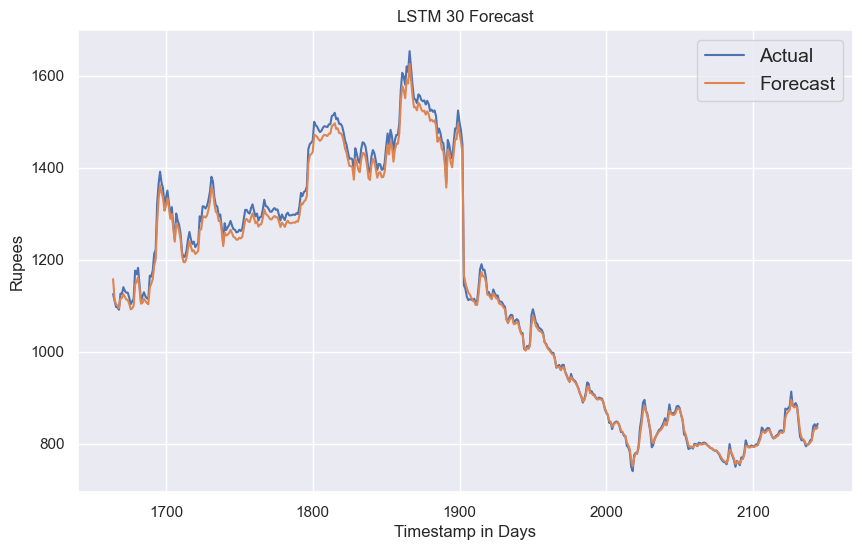

In [14]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.savefig('../Images/LSTM/LSTM FORECAST VS ACTUAL')
plt.show()

In [15]:
# calculate MAE
lstm_error=keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()
print(f"MAE FOR LSTM MODEL IS: {lstm_error}")

MAE FOR LSTM MODEL IS: 11.557371139526367
